![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [28]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# For lasso
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Run OLS
from sklearn.linear_model import LinearRegression

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV



In [29]:
rentals = pd.read_csv("rental_info.csv")

rentals.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [30]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [31]:
rentals['rental_date'] = pd.to_datetime(rentals['rental_date'])

rentals['return_date'] = pd.to_datetime(rentals['return_date'])

In [32]:
rentals[['rental_date', 'return_date']].sample(5)

,rental_date,return_date
1722,2005-05-25 19:38:46+00:00,2005-05-31 17:40:46+00:00
2671,2005-08-17 16:25:17+00:00,2005-08-19 20:12:17+00:00
60,2005-07-12 10:28:12+00:00,2005-07-19 10:19:12+00:00
1164,2005-07-11 10:59:55+00:00,2005-07-16 13:30:55+00:00
10786,2005-07-09 05:21:44+00:00,2005-07-15 00:27:44+00:00


In [33]:
rentals['rental_length_days'] = rentals['return_date'] - rentals['rental_date']

rentals['rental_length_days'] = rentals['rental_length_days'].dt.days

In [34]:
rentals[['rental_date', 'return_date', 'rental_length_days']]

,rental_date,return_date,rental_length_days
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,3
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,7
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,4
...,...,...,...
15856,2005-08-22 10:49:15+00:00,2005-08-29 09:52:15+00:00,6
15857,2005-07-31 09:48:49+00:00,2005-08-04 10:53:49+00:00,4
15858,2005-08-20 10:35:30+00:00,2005-08-29 13:03:30+00:00,9
15859,2005-07-31 13:10:20+00:00,2005-08-08 14:07:20+00:00,8


<AxesSubplot: xlabel='rental_length_days', ylabel='Count'>

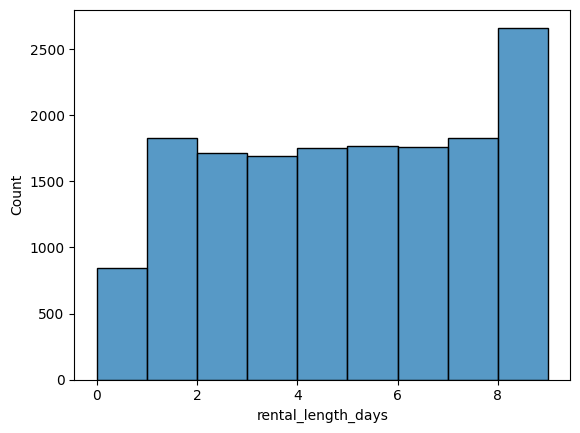

In [35]:
sns.histplot(x='rental_length_days', data=rentals, binwidth=1)

In [36]:
rentals.value_counts('special_features')

special_features
{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers}                                                      1139
{Trailers,Commentaries}                                         1129
{Trailers,"Behind the Scenes"}                                  1122
{"Behind the Scenes"}                                           1108
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries}                                                  1089
{Commentaries,"Behind the Scenes"}                              1078
{Trailers,"Deleted Scenes"}                                     1047
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Deleted Scenes"}                                 1011
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,"Delete

In [37]:
rentals['deleted_scenes'] = np.where(rentals['special_features'].str.contains('Deleted Scenes'), 1, 0)

rentals['behind_the_scenes'] = np.where(rentals['special_features'].str.contains('Behind the Scenes'), 1, 0)

rentals[['special_features', 'deleted_scenes', 'behind_the_scenes']].sample(10)

,special_features,deleted_scenes,behind_the_scenes
13191,"{Trailers,""Deleted Scenes""}",1,0
4607,"{Commentaries,""Deleted Scenes"",""Behind the Sce...",1,1
176,"{Commentaries,""Deleted Scenes"",""Behind the Sce...",1,1
8427,"{Trailers,Commentaries,""Behind the Scenes""}",0,1
1228,"{Commentaries,""Deleted Scenes""}",1,0
7394,"{Commentaries,""Deleted Scenes""}",1,0
6817,"{Trailers,""Deleted Scenes""}",1,0
14566,{Commentaries},0,0
8780,"{Trailers,""Behind the Scenes""}",0,1
11947,"{Trailers,Commentaries}",0,0


In [38]:
rentals.columns

Index(['rental_date', 'return_date', 'amount', 'release_year', 'rental_rate',
       'length', 'replacement_cost', 'special_features', 'NC-17', 'PG',
       'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2',
       'rental_length_days', 'deleted_scenes', 'behind_the_scenes'],
      dtype='object')

<AxesSubplot: >

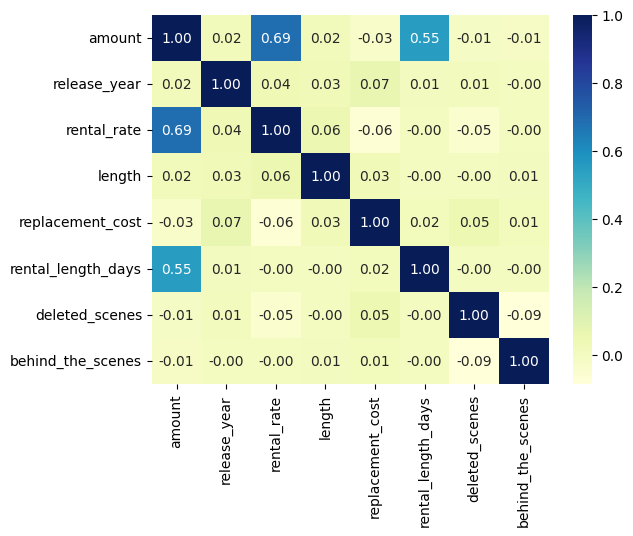

In [39]:
 corr_cols = ['amount', 'release_year', 'rental_rate', 'length', 'replacement_cost',
              'rental_length_days', 'deleted_scenes', 'behind_the_scenes']
 sns.heatmap(rentals[corr_cols].corr(), cmap='YlGnBu', annot=True, fmt=".2f")

In [40]:
# Drop unnecessary columns
cols_to_drop = ['rental_date', 'return_date', 'special_features', 'rental_length_days']

X = rentals.drop(cols_to_drop, axis=1)

X.head()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,deleted_scenes,behind_the_scenes
0,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,0,1
1,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,0,1
2,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,0,1
3,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,0,1
4,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,0,1


In [41]:
y = rentals['rental_length_days']

In [42]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [43]:
# Feature selection using Lasso

# Create the Lasso model
lasso = Lasso(alpha=0.3, random_state=9) 

# Train the model and access the coefficients
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

# Perform feature selectino by choosing columns with positive coefficients
X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

In [44]:
lasso.coef_

array([ 5.84104424e-01,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  4.36220109e-02,  3.01167812e-06, -1.52983561e-01,
       -0.00000000e+00,  0.00000000e+00])

In [45]:
X_lasso_train.head()

,amount,amount_2,length_2
6682,2.99,8.9401,8100.0
8908,4.99,24.9001,2809.0
11827,6.99,48.8601,29241.0
6153,2.99,8.9401,5329.0
10713,5.99,35.8801,14884.0


In [46]:
# Run OLS models on lasso chosen regression
ols = LinearRegression()
ols = ols.fit(X_lasso_train, y_train)
y_test_pred = ols.predict(X_lasso_test)
mse_lin_reg_lasso = mean_squared_error(y_test, y_test_pred)

mse_lin_reg_lasso

4.812297241276244

In [47]:
# Random forest hyperparameter space
param_dist = {'n_estimators': np.arange(1,101,1),
          'max_depth':np.arange(1,11,1)}

# Create a random forest regressor
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 cv=5, 
                                 random_state=9)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best hyper param
hyper_params = rand_search.best_params_

hyper_params

{'n_estimators': 51, 'max_depth': 10}

In [48]:
# Run the random forest on the chosen hyper parameters
rf = RandomForestRegressor(n_estimators=hyper_params["n_estimators"], 
                           max_depth=hyper_params["max_depth"], 
                           random_state=9)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
mse_random_forest = mean_squared_error(y_test, rf_pred)

display(mse_random_forest)

# Random forest gives lowest MSE so:
best_model = rf
best_mse = mse_random_forest

2.225667528098759